In [ ]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SEQUENCE_LENGTH=10
IMAGE_HEIGHT=128
IMAGE_WIDTH=128

In [ ]:
def create_features():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    file_namelist=[]
    DATASET_DIR_List=["/content/drive/My Drive/DeepFakeDataset/dataset10/real","/content/drive/My Drive/DeepFakeDataset/dataset10/fake"]
    frames=[]
    with open('/content/drive/My Drive/DeepFakeDataset/deepfake-detection-challenge/metadata.json', 'r') as file:
      datajson = json.load(file)
    datajsonkeys=list(datajson.keys())
    filenamelist=[]
    for DATASET_DIR in DATASET_DIR_List:
      # Get the list of video files present in the specific class name directory.
      files_list = os.listdir(DATASET_DIR)

      # Iterate through all the files present in the files list.
      for val in datajsonkeys:
        cleaned_val=val.split(".")[0]
        filenamelist.append([os.path.join(DATASET_DIR,filename) for filename in files_list if filename.startswith(cleaned_val)])

    cleaned_filenamelist=list(filter(None, filenamelist))
    for valsize in cleaned_filenamelist:
      if len(valsize)==10:
        frames_list=[]
        for newimg in valsize:
          label_string=newimg.split("/")[-2]
          normalized_frame = img_to_array(load_img(newimg)) / 255
          # Append the normalized frame into the frames list
          frames_list.append(normalized_frame)
        if label_string=="real":
          labels.append(1)
        else:
          labels.append(0)
        frames.append(frames_list)

    features = np.asarray(frames)
    labels = np.array(labels)
    return features,labels

In [ ]:
import pickle
#Taking the EDA data
with open('/content/drive/My Drive/DeepFakeDataset/Models/ConvLSTM/data30/features30.pickle', 'rb') as data:
    features = pickle.load(data)
with open('/content/drive/My Drive/DeepFakeDataset/Models/ConvLSTM/data30/labels30.pickle', 'rb') as data:
    labels = pickle.load(data)

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
print(len(one_hot_encoded_labels))

245


In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state =75 )

In [ ]:

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(2, activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 126, 126, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 63, 63, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 63, 63, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 61, 61, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 31, 31, 8)    0         
 3D)                                                             
                                                        

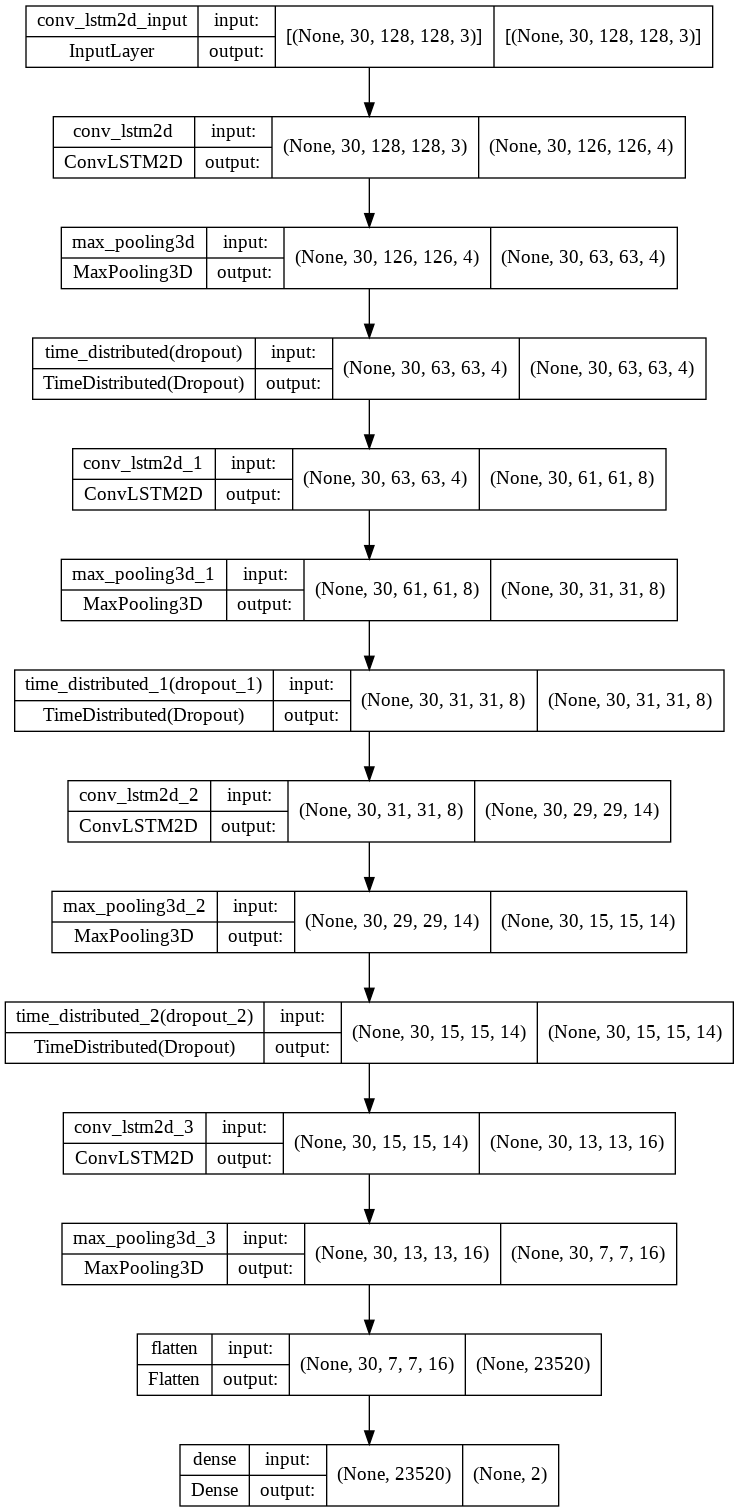

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = '/content/drive/My Drive/DeepFakeDataset/Models/ConvLSTM/data30/convlstm_model_structure_plot_30.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 35, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/35
37/37 [==============================] - 79s 2s/step - loss: 0.5610 - accuracy: 0.8014 - val_loss: 0.5509 - val_accuracy: 0.7838
Epoch 2/35
37/37 [==============================] - 55s 1s/step - loss: 0.5155 - accuracy: 0.8082 - val_loss: 0.5352 - val_accuracy: 0.7838
Epoch 3/35
37/37 [==============================] - 55s 2s/step - loss: 0.5240 - accuracy: 0.8082 - val_loss: 0.5723 - val_accuracy: 0.7838
Epoch 4/35
37/37 [==============================] - 55s 1s/step - loss: 0.5464 - accuracy: 0.8082 - val_loss: 0.5390 - val_accuracy: 0.7838
Epoch 5/35
37/37 [==============================] - 55s 1s/step - loss: 0.5022 - accuracy: 0.8082 - val_loss: 0.5220 - val_accuracy: 0.7838
Epoch 6/35
37/37 [==============================] - 56s 2s/step - loss: 0.5055 - accuracy: 0.8082 - val_loss: 0.5215 - val_accuracy: 0.7838
Epoch 7/35
37/37 [==============================] - 56s 2s/step - loss: 0.5020 - accuracy: 0.8082 - val_loss: 0.5214 - val_accuracy: 0.7838
Epoch 8/35
37/37 [==

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

2/2 [==============================] - 2s 936ms/step - loss: 0.7873 - accuracy: 0.6935


In [ ]:
import datetime as dt

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model_30___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save("/content/drive/My Drive/DeepFakeDataset/Models/ConvLSTM/data30/"+model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

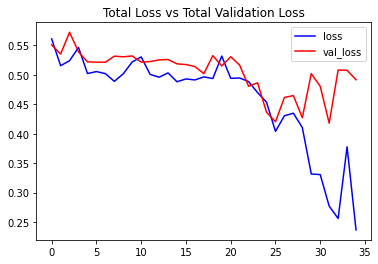

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

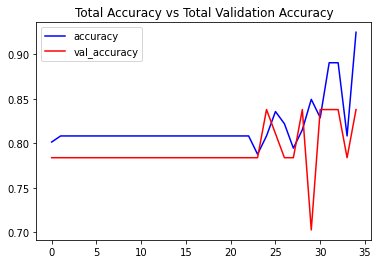

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')